# Tarea 2 - Recuperación de Información Multimedia
El siguiente reporte pretende contestar las preguntas planteadas en el enunciado. Para esto se deben cargar los descriptores, y analizar los datos aplicando las técnicas vistas en clases.

## Carga de Descriptores
Primero se cargan los descriptores, los cuales seran almacenados en las variables dataset_q_mel, dataset_r_mel, dataset_q_sift, dataset_r_sift, dataset_q_vgg y dataset_r_vgg.

In [1]:
import numpy as np
import os


def load_file(filename, num_vectors, vector_dimensions):
    assert os.path.isfile(filename), "no existe archivo " + filename
    mat = np.fromfile(filename, dtype=np.float32)
    return np.reshape(mat, (num_vectors, vector_dimensions))


def load_dataset_pair(dirname, num_vectors_q, num_vectors_r, vector_dimensions):
    file_q = "{}/Q-{}_{}_4F.bin".format(dirname, num_vectors_q, vector_dimensions)
    file_r = "{}/R-{}_{}_4F.bin".format(dirname, num_vectors_r, vector_dimensions)
    data_q = load_file(file_q, num_vectors_q, vector_dimensions)
    data_r = load_file(file_r, num_vectors_r, vector_dimensions)
    return data_q, data_r


(dataset_q_mel, dataset_r_mel) = load_dataset_pair("descriptores/MEL128", 21573, 33545, 128)
print("Q={} R={}".format(dataset_q_mel.shape, dataset_r_mel.shape))

(dataset_q_sift, dataset_r_sift) = load_dataset_pair("descriptores/SIFT", 2886, 202088, 128)
print("Q={} R={}".format(dataset_q_sift.shape, dataset_r_sift.shape))

(dataset_q_vgg, dataset_r_vgg) = load_dataset_pair("descriptores/VGG19", 842, 10171, 4096)
print("Q={} R={}".format(dataset_q_vgg.shape, dataset_r_vgg.shape))

Q=(21573, 128) R=(33545, 128)
Q=(2886, 128) R=(202088, 128)
Q=(842, 4096) R=(10171, 4096)


## Histogramas de distancias
Se pide calcular el histograma de distancias del conjunto R de cada descriptor, y determinar su dimensión intrínseca ($\rho=\mu^2/2\sigma^2$).

Primero se define una función de distancia entre dos descriptores como un arreglo de las distancias entre cada par de vectores.

In [2]:
def distance(r, l):
    dists = []
    for x in r:
        for y in l:
            dist = np.linalg.norm(x-y)
            if dist != 0:
                dists.append(dist)
    return np.array(dists)

Se importan las librerías necesarias.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import random
from scipy.stats import norm

Se define una función para graficar el histograma que recibe como parámetros el dataset, y un nombre que se desea agregar al título.

In [4]:
def histogram(input_dataset, name):
    np.random.seed(19680801)
    
    # se seleccionan 500 vectores de muestra
    dataset = input_dataset[np.random.choice(input_dataset.shape[0], 500, replace=False), :]
    
    # se obtienen las distancias
    dists = distance(dataset, dataset)
    
    # mu y sigma
    mu, std = norm.fit(dists)
    
    # dimension intrinseca
    rho = (mu**2) / (2 * (std**2))
    
    # cantidad de bins
    num_bins = 100

    fig, ax = plt.subplots()

    n, bins, patches = ax.hist(dists, num_bins)

    ax.set_xlabel('Distancia')
    ax.set_ylabel('Frecuencia')
    ax.set_title(r'Histograma de distancias ' + name + ':\n$\mu=' + str(mu) + '$, $\sigma=' + str(std) + '$, $\\rho=' + str(rho) + '$')

    plt.show()
    
    return

#### Histograma MEL128

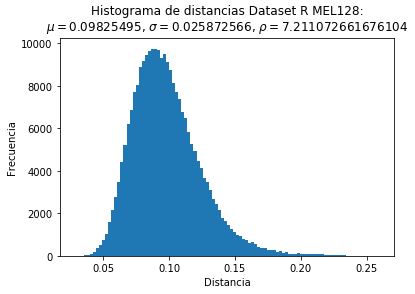

In [5]:
histogram(dataset_r_mel, "Dataset R MEL128")

#### Histograma SIFT

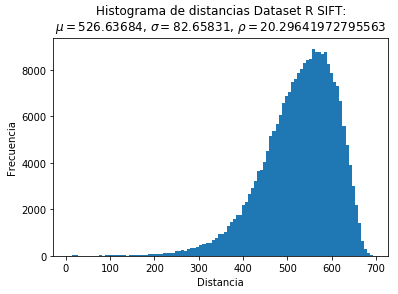

In [6]:
histogram(dataset_r_sift, "Dataset R SIFT")

#### Histograma VGG19

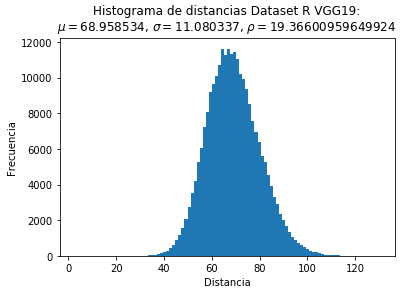

In [7]:
histogram(dataset_r_vgg, "Dataset R VGG19")

## Construcción y Aplicación de Índices

In [8]:
import pyflann
import time

#crea un objeto flann
flann = pyflann.FLANN()

### Linear Scan
Se usa Linear Scan para obtener los vecinos más cercanos reales para cada uno de los tres conjuntos. 

In [9]:
def aplicar_lscan(dataset_q, dataset_r):
    #construir el indice linear scan
    t0 = time.time()
    flann.build_index(dataset_r, algorithm="linear")
    t1 = time.time()
    print("construccion linear scan={:.1f}".format(t1-t0))

    #buscar el NN usando el ultimo indice construido (linear scan)
    t0 = time.time()
    lscan_results, lscan_dists = flann.nn_index(dataset_q, num_neighbors=1, cores=1)
    t1 = time.time()
    tiempo_lscan = t1-t0
    print("busqueda linear scan={:.1f}".format(tiempo_lscan))
    return lscan_results, lscan_dists, tiempo_lscan

In [10]:
lscan_results_mel, lscan_dists_mel, tiempo_lscan_mel = aplicar_lscan(dataset_q_mel, dataset_r_mel)

construccion linear scan=0.0
busqueda linear scan=163.8


In [11]:
lscan_results_sift, lscan_dists_sift, tiempo_lscan_sift = aplicar_lscan(dataset_q_sift, dataset_r_sift)

construccion linear scan=0.0
busqueda linear scan=131.9


In [12]:
lscan_results_vgg, lscan_dists_vgg, tiempo_lscan_vgg = aplicar_lscan(dataset_q_vgg, dataset_r_vgg)

construccion linear scan=0.0
busqueda linear scan=57.6


### KD-Tree
Se aplica el índice KD-Tree.

Función para evaluar un resultado.

In [21]:
def evaluar_resultado(results, dists, tiempo, lscan_results, lscan_dists, tiempo_lscan):
    correctas = 0
    incorrectas = 0
    iguales = 0
    for i in range(len(lscan_results)):
        #comparar las distancias
        if dists[i] == lscan_dists[i]: 
            correctas += 1
        elif dists[i] > lscan_dists[i]: 
            incorrectas += 1        
        else:
            assert False, "distancia erronea!"
        #comparar el NN
        if results[i] == lscan_results[i]: 
            iguales += 1
    efectividad = 100 * correctas / (correctas + incorrectas)
    eficiencia = 100 * tiempo / tiempo_lscan
    #print("efectividad={:.1f}% eficiencia={:.1f}% correctas={} incorrectas={} mismo-NN={}".format(efectividad, eficiencia, correctas, incorrectas, iguales))
    return efectividad, eficiencia, correctas, incorrectas, iguales

Función para construir y aplicar KD-Tree, que retorna los resultados de evaluación. Recibe los dataset, los resultados de Linear Scan y los parámetros del KD-Tree.

In [22]:
def aplicar_kdtree(dataset_q, dataset_r, lscan_results, lscan_dists, tiempo_lscan, trees, checks):
    #construir el indice kdtree con trees = trees
    t0 = time.time()
    flann.build_index(dataset_r, algorithm="kdtree", trees=trees)
    t1 = time.time()
    #print("construccion kdtree={:.1f}, trees={}".format(t1-t0, trees))

    #buscar aproximada del NN con el ultimo indice construido (kdtree)
    t0 = time.time()
    approx_results, approx_dists = flann.nn_index(dataset_q, num_neighbors=1, cores=1, checks=checks)
    t1 = time.time()
    tiempo = t1-t0
    #print("busqueda aproximada kdtree={:.1f}, trees={}".format(tiempo, trees))

    efectividad, eficiencia, correctas, incorrectas, iguales = evaluar_resultado(approx_results, approx_dists, tiempo, lscan_results, lscan_dists, tiempo_lscan)
    return efectividad, eficiencia, correctas, incorrectas, iguales

Función para aplicar múltiples KD-Trees con distintos checks y una cantidad fija de trees. Recibe como parámetros el dataset_q, el dataset_r, los resultados de Linear Scan (incluyendo resultados, distancia y tiempo), la cantidad de trees y el step para ir aumentando la cantidad de checks. Retorna una lista de tuplas con los resultados de cada iteración.

In [103]:
def aplicar_kdtrees(dataset_q, dataset_r, lscan_results, lscan_dists, tiempo_lscan, trees, step):
    # inicializar variables
    results = []
    checks = 0 - step
    
    # se hacen multiples busquedas aproximadas hasta obtener una efectividad de 95%
    while True:
        checks += step
        efectividad, eficiencia, correctas, incorrectas, iguales = aplicar_kdtree(dataset_q, dataset_r, lscan_results, lscan_dists, tiempo_lscan, trees, checks)
        results.append((efectividad, eficiencia, correctas, incorrectas, iguales))
        if efectividad >= 95:
            break
    
    # finalmente se hace una busqueda exacta para obtener el 100% de efectividad
    efectividad, eficiencia, correctas, incorrectas, iguales = aplicar_kdtree(dataset_q, dataset_r, lscan_results, lscan_dists, tiempo_lscan, trees, -1)
    results.append((efectividad, eficiencia, correctas, incorrectas, iguales))
    return results

#### MEL128

In [95]:
results_kdtree_1_mel = aplicar_kdtrees(dataset_q_mel, dataset_r_mel, lscan_results_mel, lscan_dists_mel, tiempo_lscan_mel, 1, 200)
results_kdtree_5_mel = aplicar_kdtrees(dataset_q_mel, dataset_r_mel, lscan_results_mel, lscan_dists_mel, tiempo_lscan_mel, 5, 200)
results_kdtree_10_mel = aplicar_kdtrees(dataset_q_mel, dataset_r_mel, lscan_results_mel, lscan_dists_mel, tiempo_lscan_mel, 10, 200)

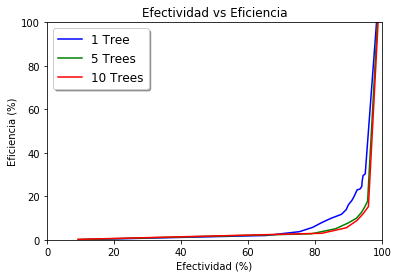

In [97]:
# obtener efectividad y eficiencia para cada caso
efectividad_kdtree_1_mel = [e[0] for e in results_kdtree_1_mel]
eficiencia_kdtree_1_mel = [e[1] for e in results_kdtree_1_mel]

efectividad_kdtree_5_mel = [e[0] for e in results_kdtree_5_mel]
eficiencia_kdtree_5_mel = [e[1] for e in results_kdtree_5_mel]

efectividad_kdtree_10_mel = [e[0] for e in results_kdtree_10_mel]
eficiencia_kdtree_10_mel = [e[1] for e in results_kdtree_10_mel]

fig, ax = plt.subplots()
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Efectividad (%)')
ax.set_ylabel('Eficiencia (%)')
ax.set_title(r'Efectividad vs Eficiencia')

# graficar
ax.plot(efectividad_kdtree_1_mel, eficiencia_kdtree_1_mel, 'b', label='1 Tree')
ax.plot(efectividad_kdtree_5_mel, eficiencia_kdtree_5_mel, 'g', label='5 Trees') 
ax.plot(efectividad_kdtree_10_mel, eficiencia_kdtree_10_mel, 'r', label='10 Trees')

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

plt.show()

En este caso se puede observar que lo mejor es siempre usar 10 trees, ya que la curva mantiene siempre mejor efectividad y eficiencia que las otras. Es decir, para MEL128 con KD-Tree nos quedamos con results_kdtree_10_mel.

#### SIFT

In [99]:
results_kdtree_1_sift = aplicar_kdtrees(dataset_q_sift, dataset_r_sift, lscan_results_sift, lscan_dists_sift, tiempo_lscan_sift, 1, 200)
results_kdtree_5_sift = aplicar_kdtrees(dataset_q_sift, dataset_r_sift, lscan_results_sift, lscan_dists_sift, tiempo_lscan_sift, 5, 200)
results_kdtree_10_sift = aplicar_kdtrees(dataset_q_sift, dataset_r_sift, lscan_results_sift, lscan_dists_sift, tiempo_lscan_sift, 10, 200)

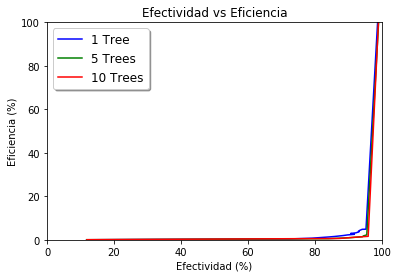

In [101]:
# obtener efectividad y eficiencia para cada caso
efectividad_kdtree_1_sift = [e[0] for e in results_kdtree_1_sift]
eficiencia_kdtree_1_sift = [e[1] for e in results_kdtree_1_sift]

efectividad_kdtree_5_sift = [e[0] for e in results_kdtree_5_sift]
eficiencia_kdtree_5_sift = [e[1] for e in results_kdtree_5_sift]

efectividad_kdtree_10_sift = [e[0] for e in results_kdtree_10_sift]
eficiencia_kdtree_10_sift = [e[1] for e in results_kdtree_10_sift]

fig, ax = plt.subplots()
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Efectividad (%)')
ax.set_ylabel('Eficiencia (%)')
ax.set_title(r'Efectividad vs Eficiencia')

# graficar
ax.plot(efectividad_kdtree_1_sift, eficiencia_kdtree_1_sift, 'b', label='1 Tree')
ax.plot(efectividad_kdtree_5_sift, eficiencia_kdtree_5_sift, 'g', label='5 Trees') 
ax.plot(efectividad_kdtree_10_sift, eficiencia_kdtree_10_sift, 'r', label='10 Trees')

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

plt.show()

En este caso se observa que todos son muy parecidos, teniendo el caso de 10 Trees una ligera ventaja. Es decir, para SIFT con KD-Tree nos quedamos con results_kdtree_10_sift.

#### VGG19

In [92]:
results_kdtree_1_vgg = aplicar_kdtrees(dataset_q_vgg, dataset_r_vgg, lscan_results_vgg, lscan_dists_vgg, tiempo_lscan_vgg, 1, 200)
results_kdtree_5_vgg = aplicar_kdtrees(dataset_q_vgg, dataset_r_vgg, lscan_results_vgg, lscan_dists_vgg, tiempo_lscan_vgg, 5, 200)
results_kdtree_10_vgg = aplicar_kdtrees(dataset_q_vgg, dataset_r_vgg, lscan_results_vgg, lscan_dists_vgg, tiempo_lscan_vgg, 10, 200)

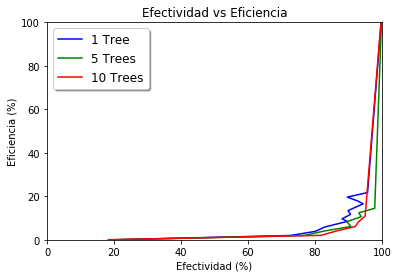

In [102]:
# obtener efectividad y eficiencia para cada caso
efectividad_kdtree_1_vgg = [e[0] for e in results_kdtree_1_vgg]
eficiencia_kdtree_1_vgg = [e[1] for e in results_kdtree_1_vgg]

efectividad_kdtree_5_vgg = [e[0] for e in results_kdtree_5_vgg]
eficiencia_kdtree_5_vgg = [e[1] for e in results_kdtree_5_vgg]

efectividad_kdtree_10_vgg = [e[0] for e in results_kdtree_10_vgg]
eficiencia_kdtree_10_vgg = [e[1] for e in results_kdtree_10_vgg]

fig, ax = plt.subplots()
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Efectividad (%)')
ax.set_ylabel('Eficiencia (%)')
ax.set_title(r'Efectividad vs Eficiencia')

# graficar
ax.plot(efectividad_kdtree_1_vgg, eficiencia_kdtree_1_vgg, 'b', label='1 Tree')
ax.plot(efectividad_kdtree_5_vgg, eficiencia_kdtree_5_vgg, 'g', label='5 Trees') 
ax.plot(efectividad_kdtree_10_vgg, eficiencia_kdtree_10_vgg, 'r', label='10 Trees')

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

plt.show()

En este caso se observa que el mejor índice depende de lo que se necesita. Con algunos valores de efectividad entre ~80% y ~95% es mejor el KD-Tree con 10 trees, pero si se necesita una efectividad mayor a 95% es mejor usar 5 trees. Vamos a asumir que no se necesita tanta efectividad y por lo tanto para VGG19 con KD-Tree nos quedamos con results_kdtree_10_vgg.

### K-Means
Se aplica el índice K-Means.

In [121]:
def aplicar_kmean(dataset_q, dataset_r, lscan_results, lscan_dists, tiempo_lscan, branching, iterations, checks):
    #construir el indice kmeans con branching = branching e iterations = iterations
    t0 = time.time()
    flann.build_index(dataset_r, algorithm="kmeans", branching=branching, iterations=iterations, cb_index=0)
    t1 = time.time()
    #print("construccion kmeans={:.1f}, branching={}, iterations={}".format(t1-t0, branching, iterations))

    #buscar aproximada del NN con el ultimo indice construido (kmeans)
    t0 = time.time()
    approx_results, approx_dists = flann.nn_index(dataset_q, num_neighbors=1, cores=1, checks=checks)
    t1 = time.time()
    tiempo = t1-t0
    #print("busqueda aproximada kdtree={:.1f}, branching={}, iterations={}".format(tiempo, branching, iterations))

    efectividad, eficiencia, correctas, incorrectas, iguales = evaluar_resultado(approx_results, approx_dists, tiempo, lscan_results, lscan_dists, tiempo_lscan)
    return efectividad, eficiencia, correctas, incorrectas, iguales

In [125]:
def aplicar_kmeans(dataset_q, dataset_r, lscan_results, lscan_dists, tiempo_lscan, branching, iterations, step):
    # inicializar variables
    results = []
    checks = 0 - step
    
    # se hacen multiples busquedas aproximadas hasta obtener una efectividad de 95%
    while True:
        checks += step
        efectividad, eficiencia, correctas, incorrectas, iguales = aplicar_kmean(dataset_q, dataset_r, lscan_results, lscan_dists, tiempo_lscan, branching, iterations, checks)
        results.append((efectividad, eficiencia, correctas, incorrectas, iguales))
        if efectividad >= 95:
            break
    
    # finalmente se hace una busqueda exacta para obtener el 100% de efectividad
    efectividad, eficiencia, correctas, incorrectas, iguales = aplicar_kmean(dataset_q, dataset_r, lscan_results, lscan_dists, tiempo_lscan, branching, iterations, -1)
    results.append((efectividad, eficiencia, correctas, incorrectas, iguales))
    return results

#### MEL128

In [126]:
results_kmeans_2_mel = aplicar_kmeans(dataset_q_mel, dataset_r_mel, lscan_results_mel, lscan_dists_mel, tiempo_lscan_mel, 2, 1, 200)

In [127]:
results_kmeans_4_mel = aplicar_kmeans(dataset_q_mel, dataset_r_mel, lscan_results_mel, lscan_dists_mel, tiempo_lscan_mel, 4, 1, 200)

In [128]:
results_kmeans_6_mel = aplicar_kmeans(dataset_q_mel, dataset_r_mel, lscan_results_mel, lscan_dists_mel, tiempo_lscan_mel, 6, 1, 200)

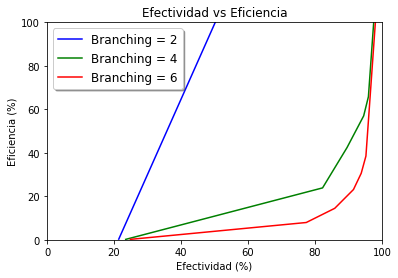

In [129]:
# obtener efectividad y eficiencia para cada caso
efectividad_kmeans_2_mel = [e[0] for e in results_kmeans_2_mel]
eficiencia_kmeans_2_mel = [e[1] for e in results_kmeans_2_mel]

efectividad_kmeans_4_mel = [e[0] for e in results_kmeans_4_mel]
eficiencia_kmeans_4_mel = [e[1] for e in results_kmeans_4_mel]

efectividad_kmeans_6_mel = [e[0] for e in results_kmeans_6_mel]
eficiencia_kmeans_6_mel = [e[1] for e in results_kmeans_6_mel]

fig, ax = plt.subplots()
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Efectividad (%)')
ax.set_ylabel('Eficiencia (%)')
ax.set_title(r'Efectividad vs Eficiencia')

# graficar
ax.plot(efectividad_kmeans_2_mel, eficiencia_kmeans_2_mel, 'b', label='Branching = 2')
ax.plot(efectividad_kmeans_4_mel, eficiencia_kmeans_4_mel, 'g', label='Branching = 4') 
ax.plot(efectividad_kmeans_6_mel, eficiencia_kmeans_6_mel, 'r', label='Branching = 6')

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

plt.show()

Claramente, el mejor caso es branching = 6.

#### SIFT

In [130]:
results_kmeans_2_sift = aplicar_kmeans(dataset_q_sift, dataset_r_sift, lscan_results_sift, lscan_dists_sift, tiempo_lscan_sift, 2, 1, 200)

In [131]:
results_kmeans_4_sift = aplicar_kmeans(dataset_q_sift, dataset_r_sift, lscan_results_sift, lscan_dists_sift, tiempo_lscan_sift, 4, 1, 200)

In [132]:
results_kmeans_6_sift = aplicar_kmeans(dataset_q_sift, dataset_r_sift, lscan_results_sift, lscan_dists_sift, tiempo_lscan_sift, 6, 1, 200)

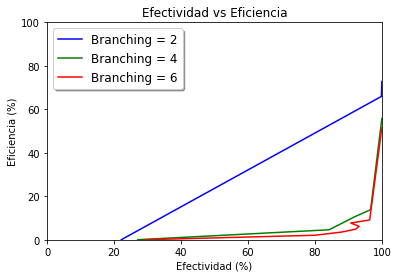

In [133]:
# obtener efectividad y eficiencia para cada caso
efectividad_kmeans_2_sift = [e[0] for e in results_kmeans_2_sift]
eficiencia_kmeans_2_sift = [e[1] for e in results_kmeans_2_sift]

efectividad_kmeans_4_sift = [e[0] for e in results_kmeans_4_sift]
eficiencia_kmeans_4_sift = [e[1] for e in results_kmeans_4_sift]

efectividad_kmeans_6_sift = [e[0] for e in results_kmeans_6_sift]
eficiencia_kmeans_6_sift = [e[1] for e in results_kmeans_6_sift]

fig, ax = plt.subplots()
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Efectividad (%)')
ax.set_ylabel('Eficiencia (%)')
ax.set_title(r'Efectividad vs Eficiencia')

# graficar
ax.plot(efectividad_kmeans_2_sift, eficiencia_kmeans_2_sift, 'b', label='Branching = 2')
ax.plot(efectividad_kmeans_4_sift, eficiencia_kmeans_4_sift, 'g', label='Branching = 4') 
ax.plot(efectividad_kmeans_6_sift, eficiencia_kmeans_6_sift, 'r', label='Branching = 6')

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

plt.show()

En este caso también se observa que con branching = 6 es mejor.

#### VGG19

In [ ]:
results_kmeans_2_vgg = aplicar_kmeans(dataset_q_vgg, dataset_r_vgg, lscan_results_vgg, lscan_dists_vgg, tiempo_lscan_vgg, 2, 1, 200)

In [ ]:
results_kmeans_4_vgg = aplicar_kmeans(dataset_q_vgg, dataset_r_vgg, lscan_results_vgg, lscan_dists_vgg, tiempo_lscan_vgg, 4, 1, 200)

In [ ]:
results_kmeans_6_vgg = aplicar_kmeans(dataset_q_vgg, dataset_r_vgg, lscan_results_vgg, lscan_dists_vgg, tiempo_lscan_vgg, 6, 1, 200)

In [ ]:
# obtener efectividad y eficiencia para cada caso
efectividad_kmeans_2_vgg = [e[0] for e in results_kmeans_2_vgg]
eficiencia_kmeans_2_vgg = [e[1] for e in results_kmeans_2_vgg]

efectividad_kmeans_4_vgg = [e[0] for e in results_kmeans_4_vgg]
eficiencia_kmeans_4_vgg = [e[1] for e in results_kmeans_4_vgg]

efectividad_kmeans_6_vgg = [e[0] for e in results_kmeans_6_vgg]
eficiencia_kmeans_6_vgg = [e[1] for e in results_kmeans_6_vgg]

fig, ax = plt.subplots()
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Efectividad (%)')
ax.set_ylabel('Eficiencia (%)')
ax.set_title(r'Efectividad vs Eficiencia')

# graficar
ax.plot(efectividad_kmeans_2_vgg, eficiencia_kmeans_2_vgg, 'b', label='Branching = 2')
ax.plot(efectividad_kmeans_4_vgg, eficiencia_kmeans_4_vgg, 'g', label='Branching = 4') 
ax.plot(efectividad_kmeans_6_vgg, eficiencia_kmeans_6_vgg, 'r', label='Branching = 6')

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

plt.show()

## Seleccionando el mejor
Para cada caso tomamos el mejor resultado de KD-Tree y K-Means y los comparamos.

### MEL128

In [ ]:
# mejor caso kdtree
efectividad_kdtree_mel = efectividad_kdtree_10_mel
eficiencia_kdtree_mel = eficiencia_kdtree_10_mel

# mejor caso kmeans
efectividad_kmeans_mel = efectividad_kmeans_6_mel
eficiencia_kmeans_mel = eficiencia_kmeans_6_mel

fig, ax = plt.subplots()
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Efectividad (%)')
ax.set_ylabel('Eficiencia (%)')
ax.set_title(r'Efectividad vs Eficiencia')

# graficar
ax.plot(efectividad_kdtree_mel, eficiencia_kdtree_mel, 'b', label='KD-Tree')
ax.plot(efectividad_kmeans_mel, eficiencia_kmeans_mel, 'g', label='K-Means') 

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

plt.show()

### SIFT

In [ ]:
# mejor caso kdtree
efectividad_kdtree_sift = efectividad_kdtree_10_sift
eficiencia_kdtree_sift = eficiencia_kdtree_10_sift

# mejor caso kmeans
efectividad_kmeans_sift = efectividad_kmeans_6_sift
eficiencia_kmeans_sift = eficiencia_kmeans_6_sift

fig, ax = plt.subplots()
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Efectividad (%)')
ax.set_ylabel('Eficiencia (%)')
ax.set_title(r'Efectividad vs Eficiencia')

# graficar
ax.plot(efectividad_kdtree_sift, eficiencia_kdtree_sift, 'b', label='KD-Tree')
ax.plot(efectividad_kmeans_sift, eficiencia_kmeans_sift, 'g', label='K-Means') 

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

plt.show()

### VGG19

In [ ]:
# mejor caso kdtree
efectividad_kdtree_vgg = efectividad_kdtree_10_vgg
eficiencia_kdtree_vgg = eficiencia_kdtree_10_vgg

# mejor caso kmeans
efectividad_kmeans_vgg = efectividad_kmeans_6_vgg
eficiencia_kmeans_vgg = eficiencia_kmeans_6_vgg

fig, ax = plt.subplots()
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Efectividad (%)')
ax.set_ylabel('Eficiencia (%)')
ax.set_title(r'Efectividad vs Eficiencia')

# graficar
ax.plot(efectividad_kdtree_vgg, eficiencia_kdtree_vgg, 'b', label='KD-Tree')
ax.plot(efectividad_kmeans_vgg, eficiencia_kmeans_vgg, 'g', label='K-Means') 

legend = ax.legend(loc='upper left', shadow=True, fontsize='large')

plt.show()